In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import hdbscan
import nltk
import spacy

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

spaci = spacy.load("en_core_web_sm")

In [2]:
df = pd.read_csv('hsbc_twitter_DATA_not GENERAL.csv')
df.rename(columns={"NEW HUMAN CATEGORY\n 0-1000 /4000-4468 Michael\n 1000-2500 Mehmet \n 2500-4000 Aryamaan":"labels"}, inplace = True)
df.head()

tweet  \
0   2  @LondOgrad Hello Eugene, we do apologise for t...   
1   8  @ncohen4 @CooperativeBank @HSBC @HSBCUKBusines...   
2   9  @sharaola Good morning, sorry for your experie...   
3  11        @Bounce_BackLoan Still not a peep from HSBC   
4  15  @djm2481 @mgcmitchell @HSBC_UK Thanks for the ...   

  HUMAN CATEGORY\n ARYAMAAN:1-1000,4000-4468\n Michael-Mehmet:1000-4000  \
0                            CUSTOMER_SERVICE_ISSUES                      
1                                     BAD REPUTATION                      
2                            CUSTOMER_SERVICE_ISSUES                      
3                                              DELAY                      
4                          Customer Service Response                      

                SUB CATEGORY                   COMMENTS  \
0                        NaN       bad customer service   
1                        NaN                        NaN   
2                        NaN       bad customer service   
3  Delay_in_bounce_back_loan  delay in bounce back loan   
4                        NaN     customer service reply   

                      labels             SUB CATEGORY.1  \
0  Customer Service Response                        NaN   
1                    General                        NaN   
2  Customer Service Response                        NaN   
3                      DELAY  Delay_in_bounce_back_loan   
4  Customer Service Response                        NaN   

                  COMMENTS.1 human category (Tarun)  SUB CATEGORY.2  \
0     customer service reply                    NaN             NaN   
1                        NaN                    NaN             NaN   
2     customer service reply                    NaN             NaN   
3  delay in bounce back loan                    NaN             NaN   
4     customer service reply                    NaN             NaN   

   COMMENTS.2             NEW CATEGORY              keyword  \
0         NaN  customer_service issues                delay   
1         NaN           Bad_reputation              unhappy   
2         NaN  customer_service issues      customerservice   
3         NaN    Delay_Bounceback_Loan  delay , no response   
4         NaN                  General          any queries   

                         human - category  \
0                                   Delay   
1               {'category': 'Reputation'   
2  {'category': 'customer_service issues'   
3         {'category': 'Bounce back loan'   
4               {'category': 'Reputation'   

                                human - Sub category  \
0                                     delay in calls   
1                     subcategory': 'Bad reputation'   
2                    subcategory': 'customerservice'   
3            subcategory': 'Bounce back loan delays'   
4  subcategory': 'General Response from Bank (tha...   

                                 Comment HUMAN CATGEORY_NEW(ARYA)  \
0                            Huge Queues  customer_service_issues   
1  worst experience from customer – mess           BAD_REPUTATION   
2             General response from bank                  General   
3                               No reply    DELAY_BOUNCEBACK_LOAN   
4             General response from bank                      NaN   

              location   COMMENTS (FROM PARIJAAT)  \
0           London, UK                        NaN   
1    Plymouth, England                        NaN   
2         Cairo, Egypt  General message from hsbc   
3  Enschede, Nederland                      DELAY   
4       United Kingdom                        NaN   

                          Category                               Sub-category  
0             {'category': 'Delay'  subcategory': 'Delay in bounce back loan'  
1        {'category': 'Reputation'            subcategory': 'Good reputation'  
2        {'category': 'Reputation'            subcategory': 'Good reputation'  
3  {'category': 'Bounce back loan'    subcategory': 'Bounce b

In [3]:
# reducing General Data 1500
drop_indices = np.random.choice(df.loc[df["labels"]=="General"].index, 1500, replace=False)
df = df.drop(drop_indices)

In [4]:
df.labels.value_counts()

General                      769
DELAY                        716
Customer Service Response    653
BAD REPUTATION               229
CUSTOMER_SERVICE_ISSUES      227
Customer Query               168
GOOD REPUTATION              101
COVID19                       50
CHURN                         37
ESG                            6
Junk                           4
Language                       2
Name: labels, dtype: int64

In [5]:
df.tweet.str.contains("bye").sum()

3

In [6]:
# label = pd.DataFrame(df.groupby("labels", as_index=False)["tweet"].apply(lambda x: " ".join(x)))
# bad_repu = label[label.labels == "BAD REPUTATION"]["reviewText"].tolist()

In [7]:
import string
def remove_punc(txt):
    txt = "".join([c for c in txt if c not in string.punctuation])
    txt = txt.replace("\n", " ")
    return txt.lower()
df.tweet = df.tweet.apply(lambda x: remove_punc(x))

In [8]:
replace_word = {"covid":"covid", "corona":"covid", "bouncebackloan":"bounce back loan",
                "noresponse":"no response","customers":"customer", "bounceback":"bounce back",
                "backloan":"back loan","on hold":"on_hold", "bbl":"bounce back loan",
                "pandemi":"covid", "any news":"any_news","give up":"give_up", "gave up":"give_up",
                "well done":"well_done"}
for key, value in replace_word.items():
    df.tweet.replace(f"\S*{key}\S*" , f"{value}", regex=True, inplace = True)

In [9]:
junk_words = "nt citi kashif a very were yet than through via here rishisunak more much getting go going ive dont able when which who year barclays hsbcin amp like an no any since after banking im there out how starlingbank starling one only again over other then am may some do cant about banks would could its even their after has them get got within now all just if what or at had hsbcukbusiness up by into will an was our us so been hsbcuk co om ke ha gone your we can from as but to the hsbc and of you for are have they is my hsbc_uk with it in on this ðÿ be not bank me that"
junk_words_list = junk_words.split(" ")

In [10]:
def remove_unicode(text):

    try:
        text = text.encode("latin_1").decode("raw_unicode_escape").encode('utf-16', 'surrogatepass').decode('utf-16')
    except:
        text = text

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", re.UNICODE)

    text = re.sub(emoji_pattern, '', text)
    text = ''.join(text.split('\\n')) # to remove uncompiled \n
    text = re.sub('\n', '', text)     # to remove compiled \n

    return text

In [11]:
def clean_data(text, small_word_lmt=0, extra_words=junk_words_list,replace_word=replace_word):
    list_data2=[]
    text = remove_unicode(text)
    sentence=text.split(' ')
    for word in sentence:
        if word == "hi":
            word = word.replace("hi", "hello")
        if not word.startswith('http') \
           and word.isalpha() \
           and word not in extra_words:
            list_data2.append(word)
    return " ".join(list_data2)
df.tweet = df.tweet.apply(lambda x: clean_data(x))

In [12]:
df.tweet.str.contains("worst").sum()

70

In [13]:
def word_root(text):
    list_data3=[]
    
    doc = spaci(text)
    for token in doc:
        if token.text=="worst" or token.text=="worse":
            lemma = token.text
        else:
            lemma = token.lemma_
        if lemma != "do":
            list_data3.append(lemma)
    return " ".join(list_data3)
df.tweet = df.tweet.apply(lambda x: word_root(x))  

In [14]:
df.tweet.str.contains("bye").sum()

5

In [15]:
word_root("worst")

'worst'

In [16]:
# adjustment for non-english words

# nltk.download('words')
# eng_words = set(nltk.corpus.words.words())
# df["eng"] = df.tweet.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i in eng_words]))
# df["noneng"] = df.tweet.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i not in eng_words]))
# df.noneng.tolist()

In [17]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in df.tweet])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(20)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [18]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in df.tweet])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(10)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [19]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [20]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [21]:
bigrams = [' '.join(x) for x in bigram_pmi.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in trigram_pmi.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [22]:
bigrams

['can not',
 'contest contestalert',
 'fromthequizmaster contest',
 'stay safe',
 'absolute joke',
 'that s',
 'what s',
 'live chat',
 'name postcode',
 'tatacrucible fromthequizmaster',
 'full name',
 'you re',
 'information hence',
 'hence request',
 'contestalert tatacrucible',
 'refer link',
 'post code',
 'direct message',
 'order assist',
 'credit card',
 'click link',
 'concerned team',
 'link below',
 'name post',
 'have nt',
 'let know',
 'send sm',
 'mobile number',
 'good morning',
 'week ago',
 'two week',
 'team touch',
 'hello mr',
 'exist customer',
 'customer care',
 'hear anything',
 'hear nothing',
 'set feeder',
 'need information',
 'assist need',
 'feeder account',
 'sorry hear',
 'please click',
 'thank write',
 'phone service',
 'worst customer',
 'still wait',
 'customer service',
 'personal account',
 'bounce back',
 'request call',
 'back loan',
 'still nothing',
 'I think',
 'call phone',
 'hello sorry',
 'apply feeder',
 'please send',
 'business customer',

In [23]:
trigrams

['sm hsbcsm register',
 'hsbcsm register mobile',
 'fromthequizmaster contest contestalert',
 'regret every second',
 'stay safe claude',
 'connect minute person',
 'tatacrucible fromthequizmaster contest',
 'absolute joke worst',
 'contest contestalert tatacrucible',
 'regard concern refer',
 'mobile number fetch',
 'send sm hsbcsm',
 'minute person set',
 'full name postcode',
 'work quickly possible',
 'team touch youalpa',
 'information hence request',
 'register mobile number',
 'number fetch detail',
 'name post code',
 'digit complaint number',
 'full name post',
 'concern refer link',
 'name postcode dm',
 'need information hence',
 'service regard concern',
 'write order assist',
 'experience business life',
 'kindly write concern',
 'person set feeder',
 'fetch detail send',
 'click link below',
 'dm direct message',
 'provide full name',
 'team check priority',
 'order assist need',
 'kindly send sm',
 'business life year',
 'direct message use',
 'second call connect',
 'ca

In [25]:
replace_ngrams = {"bounce back loan":"bounce_back_loan", "name post code":"name_post_code","full name":"full_name",
                  "credit card":"credit_card","click link below":"click_link_below","worst customer experience":"worst_customer_experience",
                  "thank respond back":"thank_respond_back","phone service team":"phone_service_team",
                  "thank write back":"thank_write_back","feeder account":"feeder_account", "still wait":"still_wait",
                  "business account":"business_account","business customer":"business_customer","good morning":"good_morning",
                  "week ago":"week_ago","post code":"post_code","click link":"click_link","let know":"let_know",
                  "call back":"call_back","personal account":"personal_account","refer link":"refer_link","link below":"link_below",
                  "name post":"name_post","hear nothing":"hear_nothing","sorry hear":"sorry_hear", "hello thank":"hello_thank",
                  "loan application":"loan_application","loan apply":"loan_apply"}
for key, value in replace_ngrams.items():
    if value == "bounce_back_loan":
        df.tweet.replace(f"\S*{key}\S*" , f"{value}", regex=True, inplace = True)
    else:
        df.tweet.replace(f"\S*{key}\S*" , f"{value} "*3, regex=True, inplace = True)
    

In [26]:
df.tweet.str.contains("worst").sum()

70

In [27]:
replace_key_words = ['delay', 'wait', 'on_hold', 'any_news', 'awful', 'disappointed', 'give_up', 'regret', 'worse', 'worst', 'unhappy', 'sucksunbelievable', 'frustrated', 'disgusted', 'happy', 'disgrace', 'awesome', 'fantastic', 'well_done', 'great', 'leave', 'bye', 'switch', 'covidenvironment', 'fossil', 'coal', 'fuel', 'climate', 'carbon', 'best', 'wonderfull']
for key_word in replace_key_words:
    df.tweet.replace(f"\S*{key_word}\S*" , f"{key_word} "*3, regex=True, inplace = True)


In [28]:
df.drop(df[df.tweet.str.contains("tatacrucible")].index, axis=0,inplace=True)

In [29]:
df_clean = df.tweet
df_clean.shape

(2910,)

In [30]:
df_clean = df_clean.dropna()
df_clean.shape

(2910,)

In [31]:
list_data = df_clean.to_list()
list_data = [str(sent) for sent in list_data]

In [32]:
from sentence_transformers import SentenceTransformer

In [33]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1

In [34]:
model=SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings1 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/91 [00:00<?, ?it/s]

In [35]:
# embeddings1[embeddings1.argmax()]

In [36]:
model=SentenceTransformer('paraphrase-distilroberta-base-v1')
embeddings2 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/91 [00:00<?, ?it/s]

In [37]:
embeddings1_norm = embeddings1 /  np.linalg.norm(embeddings1, axis=1, keepdims=True)
embeddings2_norm = embeddings2 /  np.linalg.norm(embeddings2, axis=1, keepdims=True)

In [38]:
import umap

In [39]:
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE

In [40]:
UMAP_bert1 = umap.UMAP(n_components=2).fit_transform(embeddings1)
UMAP_bert1_norm = umap.UMAP(n_components=2).fit_transform(embeddings1_norm)

UMAP_bert2 = umap.UMAP(n_components=2).fit_transform(embeddings2)
UMAP_bert2_norm = umap.UMAP(n_components=2).fit_transform(embeddings2_norm)

#n_neighbors=10, min_dist=0.0, 

In [41]:
PCA_bert1 = PCA(n_components=2).fit_transform(embeddings1)
PCA_bert1_norm = PCA(n_components=2).fit_transform(embeddings1_norm)

PCA_bert2 = PCA(n_components=2).fit_transform(embeddings2)
PCA_bert2_norm = PCA(n_components=2).fit_transform(embeddings2_norm)

In [42]:
tSNE_bert1 = TSNE(n_components=2).fit_transform(embeddings1)
tSNE_bert1_norm = TSNE(n_components=2).fit_transform(embeddings1_norm)

tSNE_bert2 = TSNE(n_components=2).fit_transform(embeddings2)
tSNE_bert2_norm = TSNE(n_components=2).fit_transform(embeddings2_norm)

In [43]:
from pyclustertend import hopkins
hopkins(UMAP_bert2,UMAP_bert2.shape[0])

0.11185079217566768

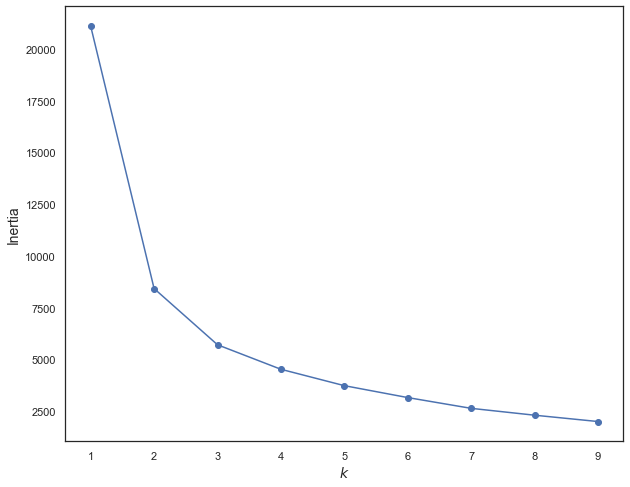

In [44]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(UMAP_bert2)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [45]:
def cluster_results(Kmeans_clusters=4):
    
    ClusterDict = {}
    dim_embeddings = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert1_norm" : UMAP_bert1_norm, 
                      "UMAP_bert2" : UMAP_bert2, "UMAP_bert2_norm" : UMAP_bert2_norm,
                      "PCA_bert1" : PCA_bert1, "PCA_bert1_norm" : PCA_bert1_norm, 
                      "PCA_bert2" : PCA_bert2, "PCA_bert2_norm" : PCA_bert2_norm,
                      "tSNE_bert1" : tSNE_bert1, "tSNE_bert1_norm" :  tSNE_bert1_norm, 
                      "tSNE_bert2" : tSNE_bert2, "tSNE_bert2_norm" : tSNE_bert2_norm}
    
    for key, val in dim_embeddings.items():
        ClusterDict[key] = KMeans(n_clusters=Kmeans_clusters).fit_predict(val)
        ClusterDict[key+"_hdbscan"] = hdbscan.HDBSCAN(min_samples = 30,
                           min_cluster_size=15,
                           metric = 'euclidean',
                           cluster_selection_epsilon = 0.25,
                           cluster_selection_method = "eom").fit_predict(val)
    return ClusterDict

In [46]:
clustering_result = cluster_results()

In [47]:
def plot(cluster = clustering_result):    
    reduced_dims = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert1_norm" : UMAP_bert1_norm, 
                    "UMAP_bert2" : UMAP_bert2, "UMAP_bert2_norm" : UMAP_bert2_norm,
                    "PCA_bert1" : PCA_bert1, "PCA_bert1_norm" : PCA_bert1_norm, 
                    "PCA_bert2" : PCA_bert2, "PCA_bert2_norm" : PCA_bert2_norm,
                    "tSNE_bert1" : tSNE_bert1, "tSNE_bert1_norm" :  tSNE_bert1_norm, 
                    "tSNE_bert2" : tSNE_bert2, "tSNE_bert2_norm" : tSNE_bert2_norm,
                    "UMAP_bert1_hdbscan" : UMAP_bert1, "UMAP_bert1_norm_hdbscan" : UMAP_bert1_norm, 
                    "UMAP_bert2_hdbscan" : UMAP_bert2, "UMAP_bert2_norm_hdbscan" : UMAP_bert2_norm,
                    "PCA_bert1_hdbscan" : PCA_bert1, "PCA_bert1_norm_hdbscan" : PCA_bert1_norm, 
                    "PCA_bert2_hdbscan" : PCA_bert2, "PCA_bert2_norm_hdbscan" : PCA_bert2_norm,
                    "tSNE_bert1_hdbscan" : tSNE_bert1, "tSNE_bert1_norm_hdbscan" :  tSNE_bert1_norm, 
                    "tSNE_bert2_hdbscan" : tSNE_bert2, "tSNE_bert2_norm_hdbscan" : tSNE_bert2_norm}

    for clustee_name, clustee in cluster.items():
        clustered = (clustee >= 0)
        reduced_dim = reduced_dims[clustee_name]
            
        print(f"----------{clustee_name}--------------------")

        unique, counts = np.unique(clustee, return_counts=True)
        print(dict(zip(unique, counts)))

        plt.scatter(reduced_dim[~clustered, 0],
                    reduced_dim[~clustered, 1],
                    c=(0.5,0.5,0.5),
                    # s=1,
                    alpha=0.5
                    )
        plt.scatter(reduced_dim[clustered, 0],
                    reduced_dim[clustered, 1],
                    c=clustee[clustered],
                    # s=1,
                    cmap='Spectral')
        plt.show()

----------UMAP_bert1--------------------
{0: 720, 1: 714, 2: 755, 3: 721}


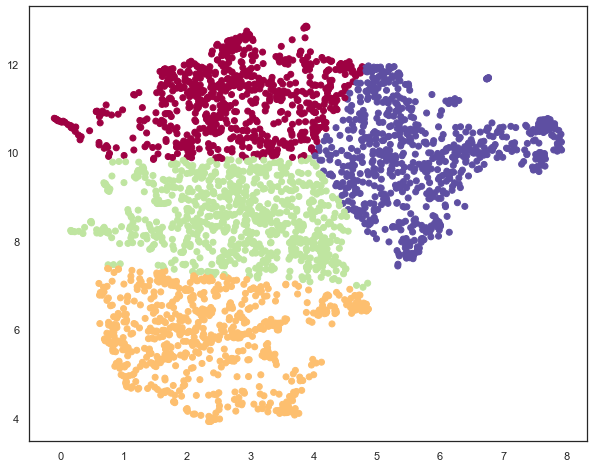

----------UMAP_bert1_hdbscan--------------------
{-1: 89, 0: 19, 1: 2802}


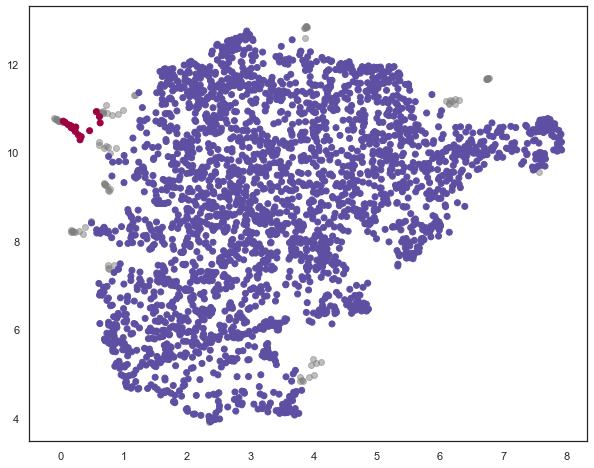

----------UMAP_bert1_norm--------------------
{0: 765, 1: 660, 2: 784, 3: 701}


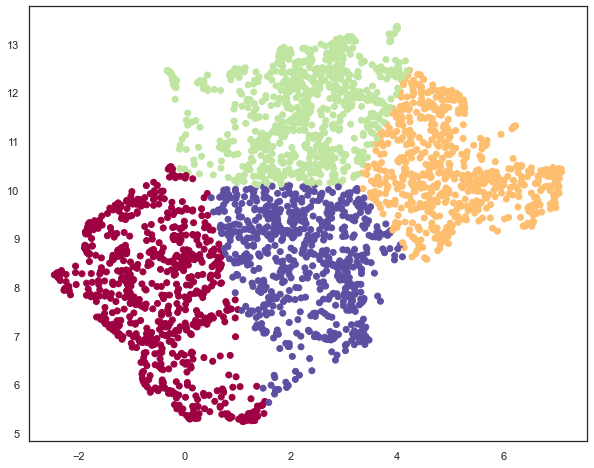

----------UMAP_bert1_norm_hdbscan--------------------
{-1: 1760, 0: 32, 1: 28, 2: 19, 3: 16, 4: 56, 5: 59, 6: 38, 7: 90, 8: 73, 9: 59, 10: 117, 11: 17, 12: 52, 13: 42, 14: 124, 15: 86, 16: 242}


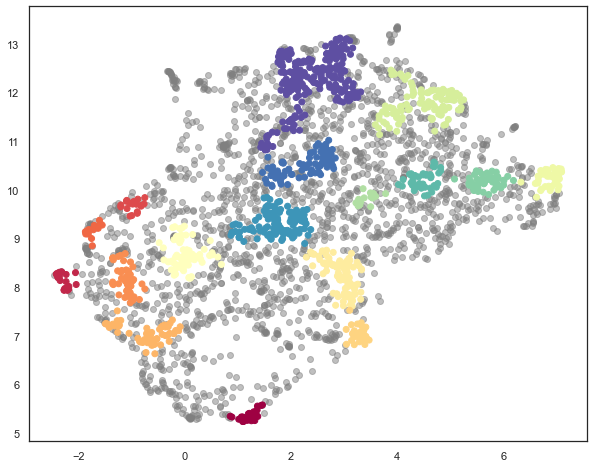

----------UMAP_bert2--------------------
{0: 791, 1: 884, 2: 576, 3: 659}


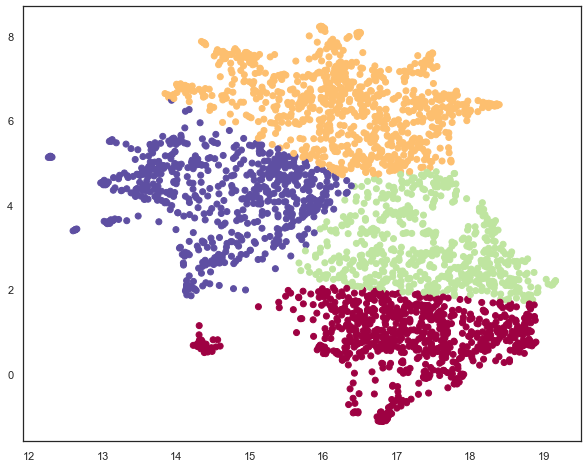

----------UMAP_bert2_hdbscan--------------------
{-1: 222, 0: 35, 1: 1643, 2: 53, 3: 127, 4: 830}


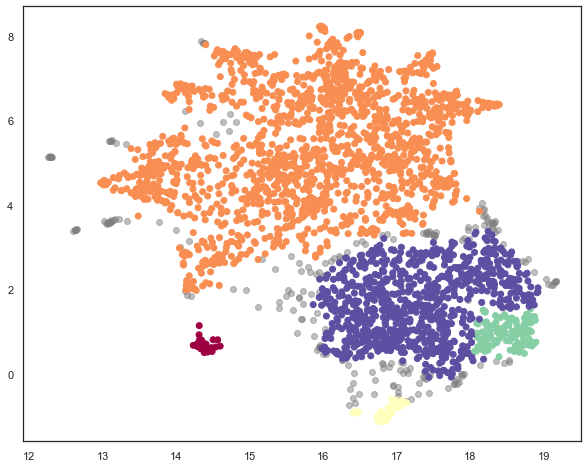

----------UMAP_bert2_norm--------------------
{0: 704, 1: 887, 2: 570, 3: 749}


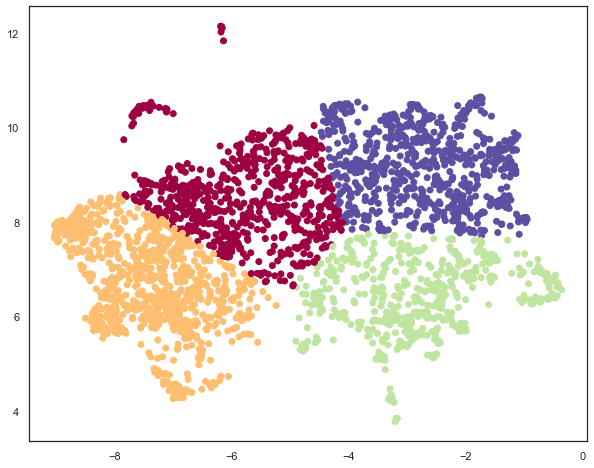

----------UMAP_bert2_norm_hdbscan--------------------
{-1: 31, 0: 42, 1: 2837}


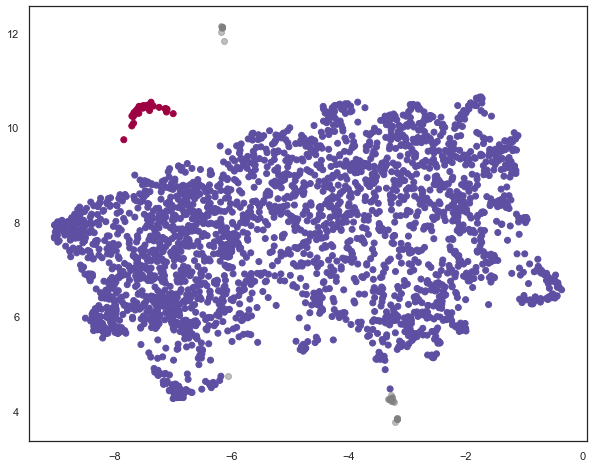

----------PCA_bert1--------------------
{0: 1014, 1: 606, 2: 1009, 3: 281}


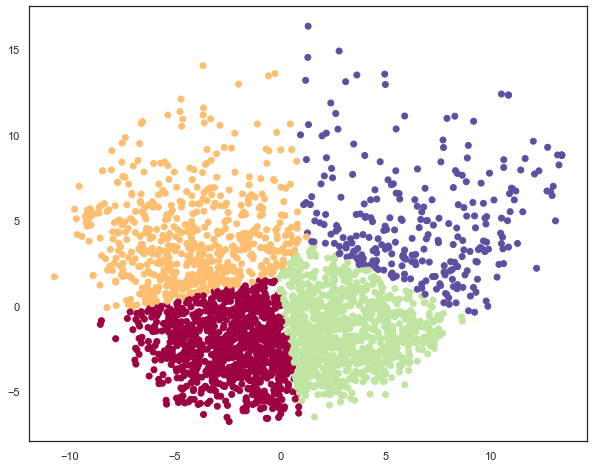

----------PCA_bert1_hdbscan--------------------
{-1: 1911, 0: 43, 1: 32, 2: 35, 3: 16, 4: 873}


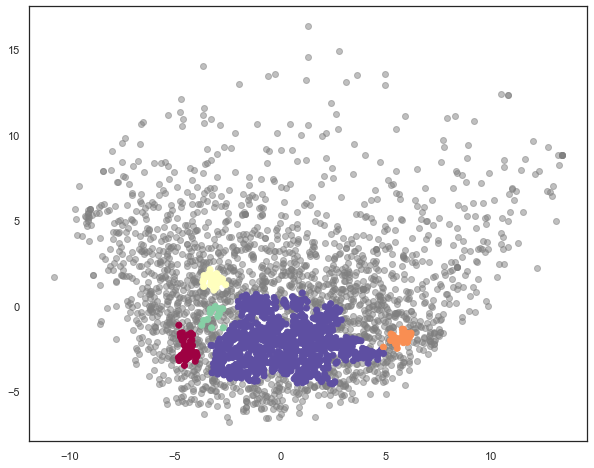

----------PCA_bert1_norm--------------------
{0: 1008, 1: 296, 2: 599, 3: 1007}


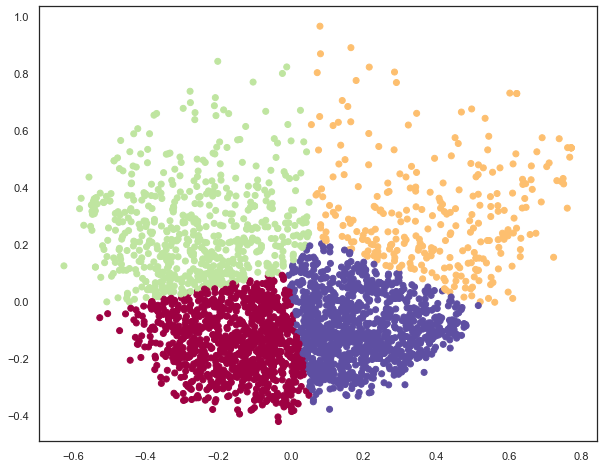

----------PCA_bert1_norm_hdbscan--------------------
{-1: 1620, 0: 30, 1: 1260}


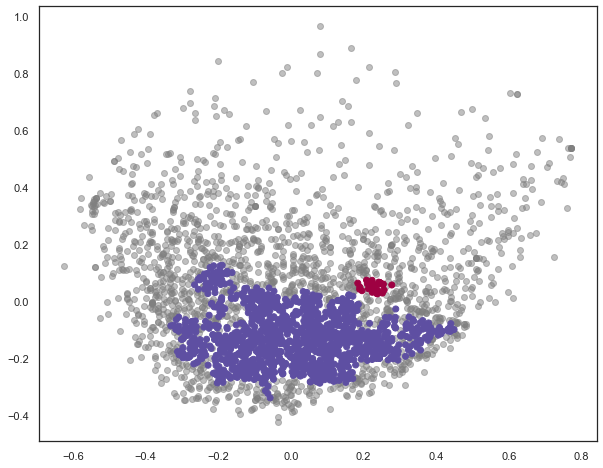

----------PCA_bert2--------------------
{0: 802, 1: 554, 2: 582, 3: 972}


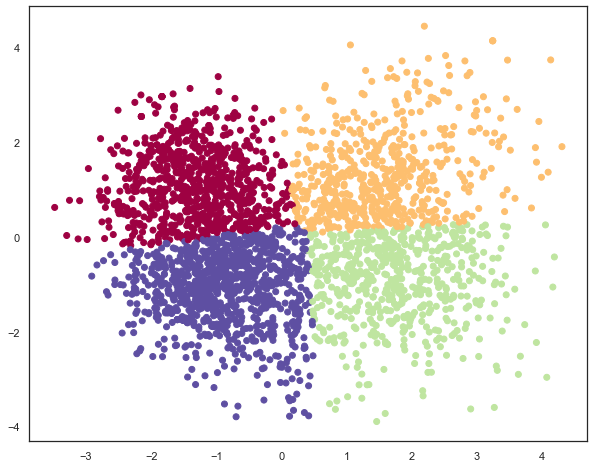

----------PCA_bert2_hdbscan--------------------
{-1: 1457, 0: 1182, 1: 34, 2: 237}


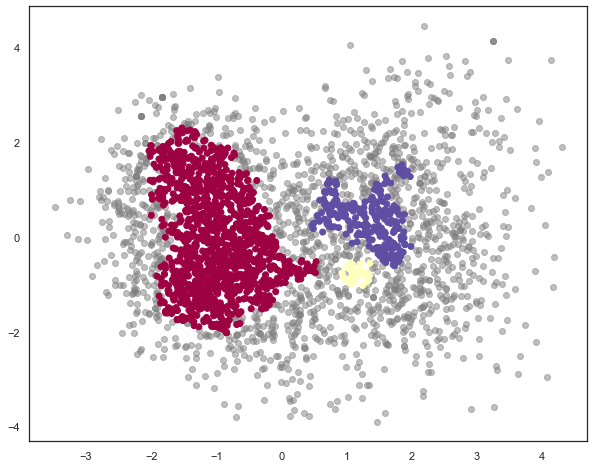

----------PCA_bert2_norm--------------------
{0: 792, 1: 505, 2: 976, 3: 637}


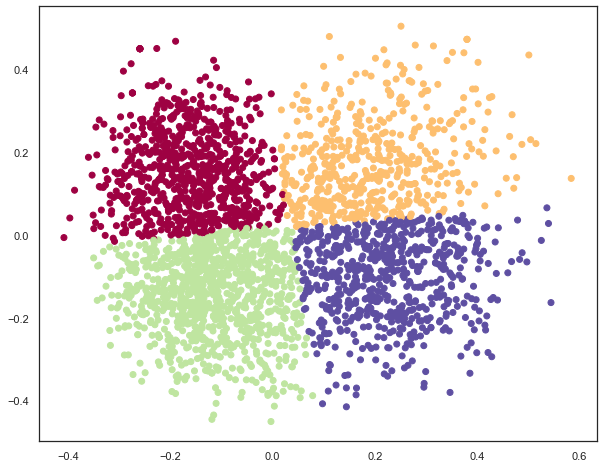

----------PCA_bert2_norm_hdbscan--------------------
{-1: 1445, 0: 309, 1: 1156}


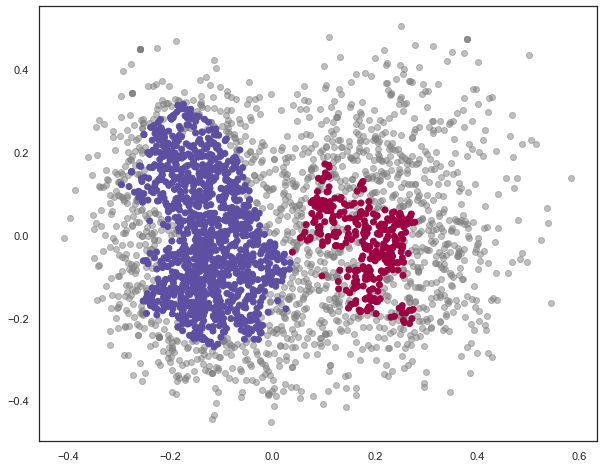

----------tSNE_bert1--------------------
{0: 807, 1: 686, 2: 807, 3: 610}


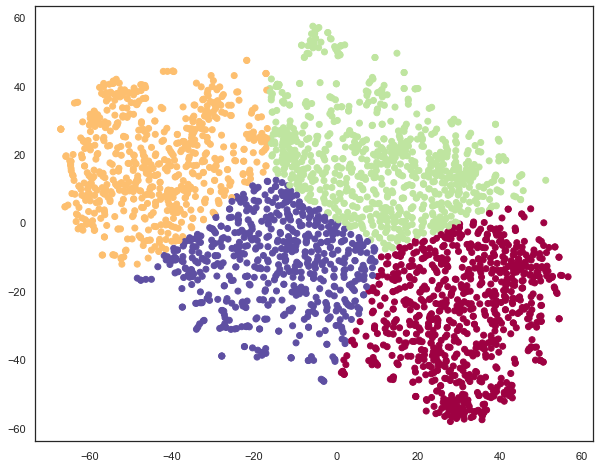

----------tSNE_bert1_hdbscan--------------------
{-1: 146, 0: 38, 1: 2726}


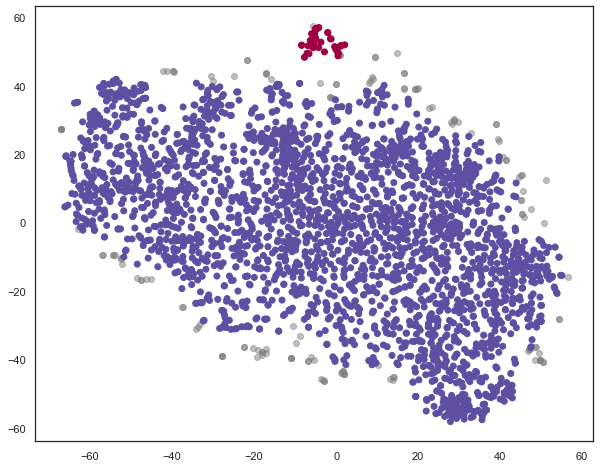

----------tSNE_bert1_norm--------------------
{0: 722, 1: 727, 2: 714, 3: 747}


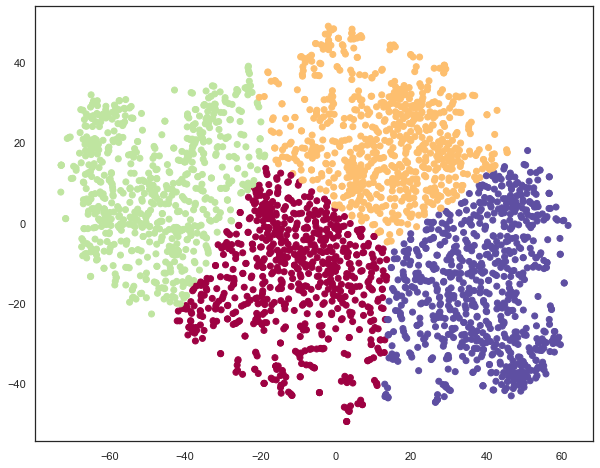

----------tSNE_bert1_norm_hdbscan--------------------
{-1: 342, 0: 43, 1: 2525}


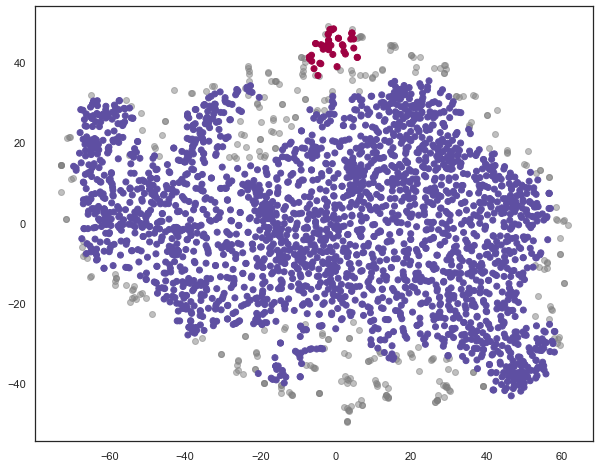

----------tSNE_bert2--------------------
{0: 686, 1: 804, 2: 771, 3: 649}


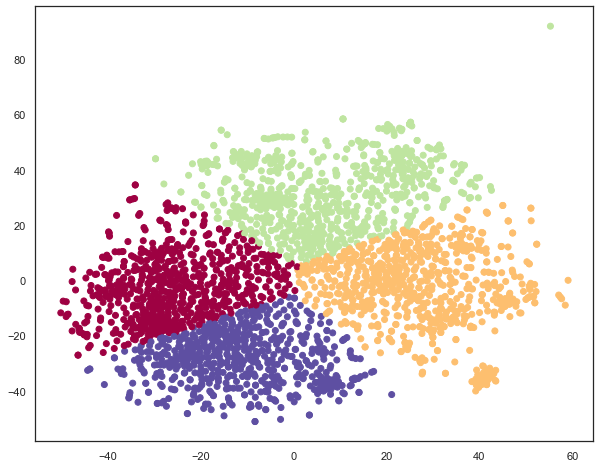

----------tSNE_bert2_hdbscan--------------------
{-1: 146, 0: 36, 1: 2728}


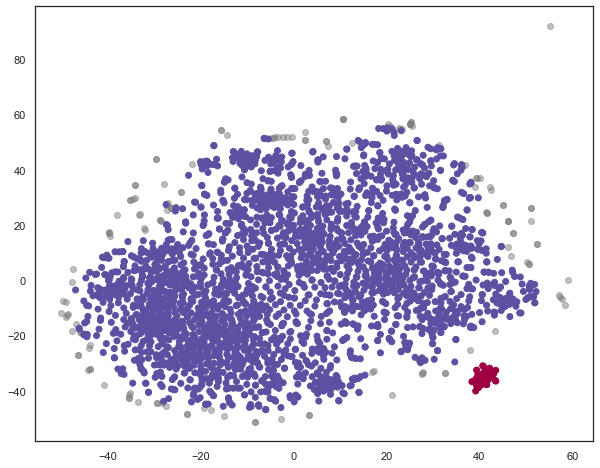

----------tSNE_bert2_norm--------------------
{0: 700, 1: 624, 2: 895, 3: 691}


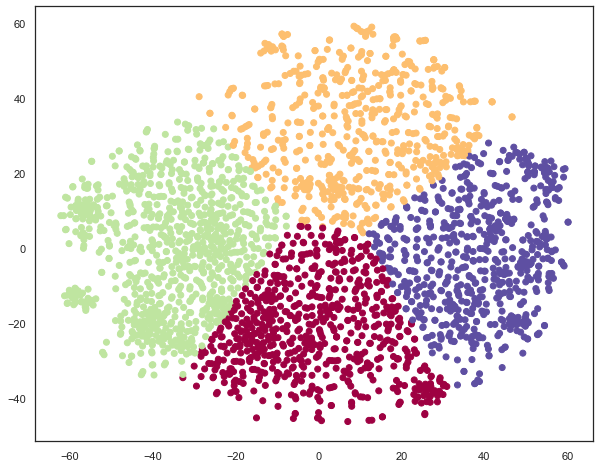

----------tSNE_bert2_norm_hdbscan--------------------
{-1: 1800, 0: 32, 1: 114, 2: 49, 3: 64, 4: 39, 5: 66, 6: 46, 7: 29, 8: 42, 9: 49, 10: 124, 11: 15, 12: 203, 13: 147, 14: 91}


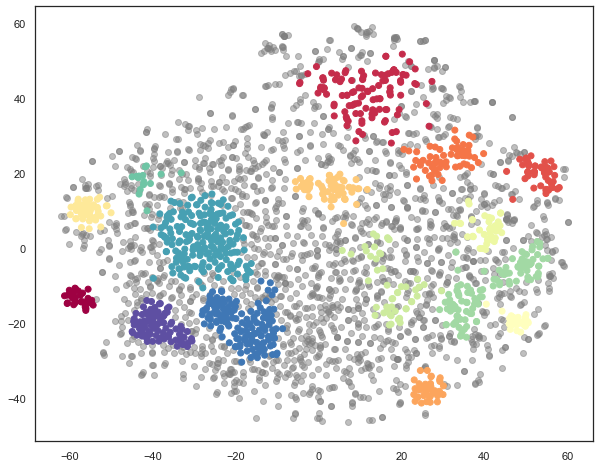

In [48]:
plot()

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidfmatrix(data, vectorizer):
    terms = vectorizer.fit_transform(data)
    return pd.DataFrame(terms.toarray(), columns = vectorizer.get_feature_names())

In [50]:
def cluster_words(clustering_result=clustering_result, top_n = 20, show_cross = False):
    for name, value in clustering_result.items():
        print(f"===================================={name}=============================================")
    
        #creatin new df in order to groupby same clusters
        cluster = value
        docs = pd.DataFrame(df_clean)
        docs["cluster"] = cluster

        labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"tweet": " ".join})

        try : 
            del labeled_docs_try
        except :
            pass
        labeled_docs_try =pd.DataFrame(df_clean)
        labeled_docs_try["labels"] = df.labels
        labeled_docs_try["cluster"] = docs.cluster
        labeled_docs_try.head(50)
        cross = pd.crosstab(labeled_docs_try.labels, labeled_docs_try.cluster)
        if show_cross:
            display(cross)
        else: pass
                
        tfidf_vec = TfidfVectorizer()
        tfidf_mat = tfidfmatrix(labeled_docs.tweet, tfidf_vec)
        
        global most_common
        most_common = pd.DataFrame({n: tfidf_mat.T[col].nlargest(top_n).index.tolist() 
                                for n, col in enumerate(tfidf_mat.T)}).T
        most_common.index = np.unique(cluster)
        display(most_common)

In [52]:
cluster_words(show_cross = True)

====================================UMAP_bert1=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              33   12   30  153
CHURN                        8    4    6   19
COVID19                     10    5   20   15
CUSTOMER_SERVICE_ISSUES     74   27   46   80
Customer Query              32   33   83   20
Customer Service Response   62  366  121  104
DELAY                      383   19  166  148
ESG                          0    1    2    3
GOOD REPUTATION             11   48   17   25
General                    105  193  262  153
Junk                         0    3    1    0
Language                     0    1    0    1

0                 1               2         3   \
0              wait  bounce_back_loan            week  week_ago   
1             thank             hello     hello_thank     happy   
2  bounce_back_loan              wait  feeder_account   account   
3             worst  bounce_back_loan            wait     awful   

               4           5                 6        7             8      9   \
0           apply         day    feeder_account  account  hear_nothing  email   
1       full_name  refer_link            please     send          team   help   
2           thank       hello  business_account   please         apply  email   
3  feeder_account    customer             delay   regret         leave  worse   

             10     11                 12     13        14           15  \
0  good_morning  still                say   call      sign        happy   
1    click_link   call         sorry_hear  great  let_know         wait   
2   application   call  business_customer   help  customer  credit_card   
3         apply  thank               call  hello      help     business   

                 16              17        18       19  
0              hour     application     delay     back  
1  bounce_back_loan  name_post_code     check   kindly  
2           receive             say  business     need  
3           account            time    please  nothing

====================================UMAP_bert1_hdbscan=============================================


cluster                    -1   0    1
labels                                
BAD REPUTATION              1   0  227
CHURN                       0   0   37
COVID19                     8   0   42
CUSTOMER_SERVICE_ISSUES     0   1  226
Customer Query              2   0  166
Customer Service Response  26  15  612
DELAY                       0   1  715
ESG                         0   0    6
GOOD REPUTATION             2   1   98
General                    48   1  664
Junk                        1   0    3
Language                    0   0    2

0      1               2       3      4       5         6   \
-1             happy   gold    good_morning   great  covid  market   nigeria   
 0      good_morning  happy           query  assist  great      jp   midweek   
 1  bounce_back_loan   wait  feeder_account   hello  thank   worst  customer   

         7         8            9                 10       11           12  \
-1  turmoil      sony  doubledigit               day      gld    infection   
 0      day  everyone        today  loan_application  twitter     week_ago   
 1  account      call  application             email    apply  hello_thank   

        13         14     15     16    17     18       19  
-1    asia  singapore    see  thank  amid  asset  england  
 0    jeff      tweep   hope  tweet  ayat   easy      ill  
 1  please   business  delay  leave    nt   send      day

====================================UMAP_bert1_norm=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              19  149   29   31
CHURN                        3   21    9    4
COVID19                      9   14   13   14
CUSTOMER_SERVICE_ISSUES     30   78   77   42
Customer Query              37   17   33   81
Customer Service Response  462   30   89   72
DELAY                        9  182  392  133
ESG                          1    3    0    2
GOOD REPUTATION             51   24   15   11
General                    141  141  125  306
Junk                         2    0    0    2
Language                     0    1    0    1

0                 1               2            3   \
0             thank             hello       full_name  hello_thank   
1             worst  bounce_back_loan            wait        awful   
2              wait  bounce_back_loan           apply     week_ago   
3  bounce_back_loan           account  feeder_account         wait   

               4                 5               6             7         8   \
0           happy        refer_link          please          send      help   
1  feeder_account             worse        customer  hear_nothing     apply   
2             day              week  feeder_account  good_morning   account   
3           thank  business_account           hello   credit_card  customer   

        9           10                11                12      13        14  \
0     team  link_below              call              wait  kindly  let_know   
1  nothing       leave              call          business  regret       day   
2    still       email       application              call     say      sign   
3    email      please  loan_application  personal_account   apply      call   

            15          16       17     18        19  
0   sorry_hear  click_link   number  great    detail  
1      account       email  service  still  disgrace  
2        thank        hour     time   back        nt  
3  application        help      say   need     leave

====================================UMAP_bert1_norm_hdbscan=============================================


cluster                    -1    0    1    2    3    4    5    6    7    8   \
labels                                                                        
BAD REPUTATION             130    3    0    0    0    0    2    0    5    2   
CHURN                       21    0    0    0    0    1    1    1    0    0   
COVID19                     46    0    0    0    0    0    0    0    2    0   
CUSTOMER_SERVICE_ISSUES    139    4    1    0    0    2    2    2    4    6   
Customer Query             107    2    2    0    0    4    1    2   10    3   
Customer Service Response  417    1   25   19   16   41   38    0    4   52   
DELAY                      358    1    0    0    0    1    1    6   17    1   
ESG                          4    0    0    0    0    0    0    0    0    0   
GOOD REPUTATION             61    0    0    0    0    1    6    0    2    1   
General                    469   19    0    0    0    6    8   27   46    8   
Junk                         2    2    0    0    0    0    0    0    0    0   
Language                     1    0    0    0    0    0    0    0    0    0   

cluster                     9    10   11   12   13   14   15   16  
labels                                                             
BAD REPUTATION              25   14    3   18    7    3    4   12  
CHURN                        3    3    1    0    0    1    2    3  
COVID19                      0    0    0    0    0    1    0    1  
CUSTOMER_SERVICE_ISSUES      6    6    1   13    2    9    6   24  
Customer Query               0    3    0    0    2   21    1   10  
Customer Service Response    0    9    3    1    2   16    3    6  
DELAY                        2   63    3    8   17   34   63  141  
ESG                          1    0    0    0    1    0    0    0  
GOOD REPUTATION             18    0    1    0    1    3    2    5  
General                      4   19    5   12    9   36    5   40  
Junk                         0    0    0    0    0    0    0    0  
Language                     0    0    0    0    1    0    0    0

0                 1                   2                 3   \
-1               wait  bounce_back_loan               thank             happy   
 0           complain              form                  dm              link   
 1         refer_link       hello_thank  phone_service_team            assist   
 2      inconvenience             cause               hello           apology   
 3   click_link_below         full_name      name_post_code        sorry_hear   
 4               wait              team              kindly             hello   
 5              happy       hello_thank               great        click_link   
 6   bounce_back_loan              same          lloydsbank        rickyacook   
 7   bounce_back_loan    feeder_account    personal_account           account   
 8           let_know             thank               email  phishinghsbccouk   
 9              worst            regret      feeder_account          absolute   
 10      hear_nothing              wait             nothing  bounce_back_loan   
 11             email  bounce_back_loan                rate  business_account   
 12             awful          customer            disgrace  bounce_back_loan   
 13  bounce_back_loan    feeder_account               delay  business_account   
 14  bounce_back_loan    feeder_account               email           account   
 15              wait  bounce_back_loan      feeder_account             apply   
 16              wait          week_ago    bounce_back_loan              week   

                   4                 5            6            7          8   \
-1              hello    feeder_account      account    full_name      delay   
 0          complaint              send       beread      curious  doesthank   
 1              hence              call        order  information    request   
 2       good_morning             thank   understand      connect         mr   
 3                 dm             share        start        check  name_post   
 4              thank         concerned  hello_thank       nilesh   patience   
 5              thank  thank_write_back         help        hello       glad   
 6        philpelucha             block     hightonk         time       turn   
 7              money               pay        debit  credit_card       card   
 8               text             hello     phishing         link       scam   
 9             person             every         life         wait    connect   
 10             still             never          day   loan_apply     switch   
 11         post_code             apply      decline  greenmotion        nzs   
 12           service      disappointed          try         hour      worse   
 13             leave             apply         many        money       fail   
 14  loan_application  business_account  application          ceo      apply   
 15               day             still  application        delay   let_know   
 16    feeder_account             apply         last          day       sign   

              9                 10                11            12  \
-1         great              help            please  good_morning   
 0      literaly       marketmaker             mayis         noand   
 1          need             write           concern         phone   
 2        nilesh         apologize        frustrated        regret   
 3         hello             thank               ank           ill   
 4        revert        appreciate              send         check   
 5       channel         full_name              safe        ensure   
 6         bouce              defo    gingerskitchen          ouch   
 7          fund  loan_application             apply        credit   
 8   hello_thank            attach        screenshot       message   
 9        fossil              fuel              joke          year   
 10        apply             leave              tell          week   
 11    something               car           dev

====================================UMAP_bert2=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              64   36   34   94
CHURN                       20    3    6    8
COVID19                      1    3    1   45
CUSTOMER_SERVICE_ISSUES     38   55   76   58
Customer Query              37   52   16   63
Customer Service Response   11  544   55   43
DELAY                      382   13  299   22
ESG                          0    1    0    5
GOOD REPUTATION             12   38   12   39
General                    224  134   76  279
Junk                         0    3    0    1
Language                     0    0    1    1

0                 1        2      3            4   \
0  bounce_back_loan    feeder_account    apply  email         wait   
1             thank         full_name    hello  happy  hello_thank   
2              wait  bounce_back_loan    delay    day        apply   
3             worst       credit_card  account  thank        covid   

                 5            6         7                 8           9   \
0             leave      account       day  business_account         say   
1            please   refer_link      send              team        call   
2  loan_application  application      week    feeder_account  loan_apply   
3    feeder_account        money  customer            regret        help   

           10                11              12        13          14  \
0        week  personal_account     application      sign       still   
1  link_below              help  name_post_code    kindly  sorry_hear   
2        call             still        customer  business        hour   
3        gold             hello             new       pay        make   

           15         16            17       18        19  
0    week_ago   customer  hear_nothing     call  business  
1  click_link   let_know        assist   number    detail  
2        time  call_back       account     tell      loan  
3     payment      worse      business  service    please

====================================UMAP_bert2_hdbscan=============================================


cluster                    -1   0    1   2   3    4
labels                                             
BAD REPUTATION             17   3  137   0  13   58
CHURN                       2   8   12   0   1   14
COVID19                    16   0   33   0   0    1
CUSTOMER_SERVICE_ISSUES    16   0  161   0   4   46
Customer Query              8   3  124   2   5   26
Customer Service Response  23   1  611   2   0   16
DELAY                      53  12   61  12  74  504
ESG                         1   0    5   0   0    0
GOOD REPUTATION             6   0   82   1   0   12
General                    80   8  408  36  30  151
Junk                        0   0    4   0   0    0
Language                    0   0    2   0   0    0

0                 1          2                  3   \
-1              wait  bounce_back_loan       gold  business_customer   
 0             leave   michaelblackcab       wait   bounce_back_loan   
 1             thank             hello  full_name              worst   
 2  bounce_back_loan        lloydsbank     payout               hear   
 3    feeder_account  bounce_back_loan      apply               wait   
 4              wait  bounce_back_loan      apply              email   

             4                 5            6               7       8   \
-1      nigeria              sony          day           covid   happy   
 0        worst  business_account    call_back  feeder_account  online   
 1  hello_thank            please        happy     credit_card    call   
 2         time             today       anyone            turn    well   
 3      account              week          day           email    call   
 4          day              week  application  feeder_account    sign   

                  9                 10           11            12      13  \
-1  personal_account             worst  application      customer  market   
 0           manager              case   loan_apply          sony    time   
 1           account              send   refer_link         great    team   
 2         telegraph             apply         good           pay   still   
 3         call_back  personal_account          say  hear_nothing  feeder   
 4  business_account      hear_nothing      account      business     say   

                  14        15        16          17        18  \
-1  business_account       new  unilever      fossil      fuel   
 0       application   account       bye       waste      year   
 1              help  let_know    kindly  sorry_hear  customer   
 2             lloyd  anything      luck        most        nt   
 3              open  customer     phone        tell  week_ago   
 4          customer     still  week_ago  loan_apply      tell   

                  19  
-1             hello  
 0             apply  
 1            number  
 2          imminent  
 3              hear  
 4  loan_application

====================================UMAP_bert2_norm=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              65   74   63   26
CHURN                       15   13    8    1
COVID19                      5    2   41    2
CUSTOMER_SERVICE_ISSUES     98   47   30   52
Customer Query              50   37    8   73
Customer Service Response   80   18   66  489
DELAY                      259  439    7   11
ESG                          0    0    6    0
GOOD REPUTATION             15   17   56   13
General                    116  238  280   79
Junk                         0    0    4    0
Language                     1    0    1    0

0                 1          2            3       4   \
0              wait  bounce_back_loan      leave      account   delay   
1  bounce_back_loan    feeder_account       wait        apply   email   
2             worst             happy      thank        great   covid   
3             thank             hello  full_name  hello_thank  please   

                 5            6      7                 8             9   \
0  loan_application   loan_apply  apply               day         thank   
1               day      account    say  business_account          week   
2    feeder_account       regret   gold              help  good_morning   
3        refer_link  credit_card   send              team      let_know   

            10           11       12                13         14  \
0  application     customer     call              week  call_back   
1     week_ago  application    still  personal_account       sign   
2        worse      service  support          business      today   
3   link_below         call    happy    name_post_code       help   

             15          16        17                18        19  
0          help        time     still             hello       try  
1  hear_nothing    customer  business              back      call  
2       climate        fuel     money  bounce_back_loan  customer  
3    sorry_hear  click_link    detail            number        dm

====================================UMAP_bert2_norm_hdbscan=============================================


cluster                    -1   0    1
labels                                
BAD REPUTATION              0   4  224
CHURN                       0   8   29
COVID19                     2   0   48
CUSTOMER_SERVICE_ISSUES     0   0  227
Customer Query              0   4  164
Customer Service Response   0   3  650
DELAY                       1  12  703
ESG                         0   0    6
GOOD REPUTATION             1   0  100
General                    27  11  675
Junk                        0   0    4
Language                    0   0    2

0                 1                 2                3   \
-1   gold            market           turmoil      doubledigit   
 0  leave              wait  bounce_back_loan  michaelblackcab   
 1   wait  bounce_back_loan             thank           please   

                4                 5          6      7        8        9   \
-1             gld              amid       asia  asset  england   growth   
 0  feeder_account  business_account  call_back  worst  manager  account   
 1           hello    feeder_account      apply   call    worst     send   

         10      11        12           13     14           15         16  \
-1  million  wealth       bar          tap   lose          see        day   
 0     case  online      time  application   help   loan_apply      apply   
 1    happy    help  customer      account  email  hello_thank  full_name   

       17        18         19  
-1  great  physical  dislocate  
 0    new   process      thank  
 1   team     delay         nt

====================================PCA_bert1=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              55  135   23   15
CHURN                       12   18    5    2
COVID19                     21   15    9    5
CUSTOMER_SERVICE_ISSUES     93   75   38   21
Customer Query              58   16   78   16
Customer Service Response   95   41  469   48
DELAY                      453  150  103   10
ESG                          1    4    1    0
GOOD REPUTATION             20   22   36   23
General                    205  129  241  138
Junk                         0    0    1    3
Language                     0    1    1    0

0                 1                 2      3                 4   \
0   wait  bounce_back_loan    feeder_account  email             apply   
1  worst              wait  bounce_back_loan  awful    feeder_account   
2  thank             hello       hello_thank   wait  bounce_back_loan   
3  thank             hello            please   help  bounce_back_loan   

         5          6       7                 8         9         10  \
0   account       week     day  business_account  week_ago      call   
1  customer      worse  regret             apply      call  business   
2     happy  full_name  please        refer_link      send      help   
3     great      happy    send          customer  let_know     still   

            11       12            13     14        15        16       17  \
0  application      say      customer   help     still     thank    delay   
1        delay    leave  hear_nothing    day  disgrace      week  service   
2         team     call       account  great    number  let_know   kindly   
3         wait  welcome            dm   know      safe   account    check   

             18          19  
0          sign        time  
1       nothing        time  
2  good_morning  click_link  
3           day        give

====================================PCA_bert1_hdbscan=============================================


cluster                     -1   0   1   2   3    4
labels                                             
BAD REPUTATION             189   4   0   6   1   28
CHURN                       25   2   0   0   0   10
COVID19                     33   1   0   1   2   13
CUSTOMER_SERVICE_ISSUES    158   5   0   1   1   62
Customer Query              94   3   2   2   0   67
Customer Service Response  410   1  25   4   3  210
DELAY                      427  24   1  17   8  239
ESG                          5   0   0   0   0    1
GOOD REPUTATION             73   0   1   0   0   27
General                    490   3   3   4   1  212
Junk                         3   0   0   0   0    1
Language                     2   0   0   0   0    0

0                 1                   2               3   \
-1         wait             worst    bounce_back_loan           thank   
 0         wait  bounce_back_loan      feeder_account        week_ago   
 1  hello_thank        refer_link  phone_service_team          assist   
 2         wait  bounce_back_loan               apply  feeder_account   
 3         wait  bounce_back_loan               apply            call   
 4         wait  bounce_back_loan      feeder_account           thank   

                4            5                 6                 7   \
-1  feeder_account        happy             hello             apply   
 0            last  application              week               two   
 1           write  information             hence             order   
 2    hear_nothing         fail            charge           account   
 3           thank          due           further  loan_application   
 4           hello      account  business_account            please   

           8      9         10           11            12           13  \
-1  full_name   call  customer          day        please  hello_thank   
 0      email  month     apply         work           say         take   
 1    request  thank      need         call     full_name        great   
 2     please   case  let_know         text        should         time   
 3   business  covid       bit   loan_apply      week_ago          day   
 4      email   send     apply  credit_card  good_morning        happy   

            14                15           16            17        18  \
-1     account              help  credit_card           say     email   
 0         day          business     customer  hear_nothing     leave   
 1  link_below  thank_write_back       please       swansea   concern   
 2        week           weather       answer            be   decline   
 3        sink         call_back     customer         delay     email   
 4    customer               say          day          help  let_know   

                19  
-1            week  
 0           still  
 1           hello  
 2      loan_apply  
 3  feeder_account  
 4            call

====================================PCA_bert1_norm=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              55   16  133   24
CHURN                       12    2   18    5
COVID19                     21    5   15    9
CUSTOMER_SERVICE_ISSUES     93   21   75   38
Customer Query              58   18   16   76
Customer Service Response   94   52   40  467
DELAY                      455   10  145  106
ESG                          1    0    4    1
GOOD REPUTATION             17   25   22   37
General                    201  143  130  239
Junk                         0    3    0    1
Language                     0    1    1    0

0                 1                 2      3                 4   \
0   wait  bounce_back_loan    feeder_account  email             apply   
1  thank             hello             great   help            please   
2  worst              wait  bounce_back_loan  awful    feeder_account   
3  thank             hello       hello_thank   wait  bounce_back_loan   

                 5       6          7                 8         9         10  \
0           account    week        day  business_account  week_ago      call   
1  bounce_back_loan   happy       send          customer        dm  let_know   
2          customer   worse     regret             apply      call     leave   
3             happy  please  full_name        refer_link      send      team   

            11     12            13      14        15        16       17  \
0  application    say          help   still  customer     delay     sign   
1        still   wait       welcome     day      know      safe     stay   
2     business  delay  hear_nothing     day  disgrace      week  service   
3         help   call       account  number     great  let_know   kindly   

             18          19  
0         thank        time  
1           zar     account  
2       nothing        year  
3  good_morning  click_link

====================================PCA_bert1_norm_hdbscan=============================================


cluster                     -1   0    1
labels                                 
BAD REPUTATION             174   1   53
CHURN                       23   0   14
COVID19                     29   0   21
CUSTOMER_SERVICE_ISSUES    145   1   81
Customer Query              75   1   92
Customer Service Response  323   9  321
DELAY                      355   2  359
ESG                          5   0    1
GOOD REPUTATION             67   1   33
General                    417  15  281
Junk                         3   0    1
Language                     2   0    0

0                 1               2      3               4      5   \
-1       wait  bounce_back_loan           worst  thank  feeder_account    day   
 0  full_name       doubledigit          please    see           thank   asia   
 1       wait  bounce_back_loan  feeder_account  thank         account  hello   

       6         7        8       9         10     11                12    13  \
-1  hello  customer  account   apply      call  email              time  week   
 0  asset    growth    hello  wealth     happy  sorry  bounce_back_loan    dm   
 1    day     email   please    send  customer  apply             happy  help   

        14     15           16             17                18     19  
-1  please  leave         help       business             happy  still  
 0    help   look         well  lawuntoitself  click_link_below    far  
 1    call  still  hello_thank           week              time     nt

====================================PCA_bert2=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              75   51   28   74
CHURN                        9   13    9    6
COVID19                     46    1    0    3
CUSTOMER_SERVICE_ISSUES     36   20   39  132
Customer Query              47   27   17   77
Customer Service Response  114    6   18  515
DELAY                       27  249  379   61
ESG                          6    0    0    0
GOOD REPUTATION             45    9   27   20
General                    391  176   65   81
Junk                         4    0    0    0
Language                     2    0    0    0

0                 1               2          3   \
0             thank             happy           great      covid   
1  bounce_back_loan    feeder_account           apply    account   
2              wait  bounce_back_loan  feeder_account      apply   
3             thank             hello            wait  full_name   

                 4            5      6            7            8   \
0           account  credit_card  worst         help         gold   
1  business_account     business   week          day        still   
2             worst          day  email  application         call   
3       hello_thank       please   call   refer_link  credit_card   

                 9                 10            11         12          13  \
0             money             hello           new     please     support   
1  personal_account               say      customer      leave         pay   
2              week  business_account  hear_nothing  call_back     account   
3             happy              send          help       team  sorry_hear   

        14        15        16      17        18       19  
0     sony      look       see  market     awful  climate  
1    email     money        nt    sign      take    today  
2      say  business  customer    sign     still     tell  
3  account  customer    number  kindly  let_know     need

====================================PCA_bert2_hdbscan=============================================


cluster                     -1    0   1    2
labels                                      
BAD REPUTATION              99  108   2   19
CHURN                       17   12   0    8
COVID19                     22   28   0    0
CUSTOMER_SERVICE_ISSUES     99  110   2   16
Customer Query              59  100   0    9
Customer Service Response  226  425   2    0
DELAY                      515   51  16  134
ESG                          3    3   0    0
GOOD REPUTATION             57   33   9    2
General                    354  307   3   49
Junk                         2    2   0    0
Language                     0    2   0    0

0                 1                 2       3            4   \
-1              wait  bounce_back_loan    feeder_account   thank        apply   
 0             hello             thank         full_name   happy  credit_card   
 1             worst    feeder_account  bounce_back_loan  regret         wait   
 2  bounce_back_loan    feeder_account              wait   apply      account   

        5            6                 7       8         9            10  \
-1   hello          day              call   email     still  application   
 0  please  hello_thank           account    help  let_know         send   
 1    call     absolute             apply  second   connect          day   
 2   email        leave  business_account   still       day         week   

          11                12        13                14        15  \
-1      week           account     worst  business_account  customer   
 0      team              call  customer        link_below     worst   
 1     every               set      year          business      joke   
 2  customer  personal_account       say              take  business   

              16          17      18              19  
-1          help       happy  please            time  
 0       service  sorry_hear    need  name_post_code  
 1          life      minute  person             say  
 2  hear_nothing        fund      nt     application

====================================PCA_bert2_norm=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              74   47   72   35
CHURN                        9   10    7   11
COVID19                     46    1    3    0
CUSTOMER_SERVICE_ISSUES     42   16  127   42
Customer Query              41   21   84   22
Customer Service Response  107    6  520   20
DELAY                       25  225   60  406
ESG                          6    0    0    0
GOOD REPUTATION             47    8   19   27
General                    389  170   81   73
Junk                         4    0    0    0
Language                     2    0    0    0

0                 1               2            3          4   \
0             thank             happy           great        covid    account   
1  bounce_back_loan    feeder_account         account        apply       week   
2             thank             hello            wait  hello_thank  full_name   
3              wait  bounce_back_loan  feeder_account        apply      worst   

         5            6                 7            8             9   \
0     worst         help              gold  credit_card         money   
1  business          day               say        still      customer   
2    please  credit_card              call   refer_link         happy   
3     email          day  business_account  application  hear_nothing   

                 10       11       12        13          14                15  \
0             awful  support      new      sony       hello            please   
1  loan_application      pay    leave     money          nt  business_account   
2              send     team     help   account  link_below          customer   
3              call     week  account  week_ago    customer             still   

          16        17          18            19  
0     market       see     climate          fuel  
1       loan      sign        take          wait  
2     number    kindly  sorry_hear  good_morning  
3  call_back  business         say          sign

====================================PCA_bert2_norm_hdbscan=============================================


cluster                     -1    0    1
labels                                  
BAD REPUTATION              94   25  109
CHURN                       17    7   13
COVID19                     20    0   30
CUSTOMER_SERVICE_ISSUES    102   16  109
Customer Query              64   10   94
Customer Service Response  253    6  394
DELAY                      493  174   49
ESG                          4    0    2
GOOD REPUTATION             44   18   39
General                    350   53  310
Junk                         1    0    3
Language                     0    0    2

0                 1               2          3      4   \
-1              wait  bounce_back_loan  feeder_account      thank  apply   
 0  bounce_back_loan              wait  feeder_account      worst  apply   
 1             thank             hello          please  full_name  happy   

         5            6            7            8         9         10    11  \
-1    hello         call          day      account     email    please  week   
 0    email          day  application         call       say     leave  week   
 1  account  credit_card         help  hello_thank  customer  let_know  wait   

          12       13           14                15            16      17  \
-1  customer     help  application             happy          send   still   
 0  business  account        still  business_account  hear_nothing  regret   
 1      call     send         team             worst          need    time   

         18                19  
-1     time  business_account  
 0     take              tell  
 1  service             great

====================================tSNE_bert1=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION             161   13   30   24
CHURN                       21    3    6    7
COVID19                     21    7    6   16
CUSTOMER_SERVICE_ISSUES     94   24   70   39
Customer Query              20   28   52   68
Customer Service Response   27  377  100  149
DELAY                      281   12  326   97
ESG                          3    1    0    2
GOOD REPUTATION             28   50    7   16
General                    149  165  208  191
Junk                         0    3    0    1
Language                     1    1    0    0

0                 1               2         3             4   \
0             worst  bounce_back_loan            wait     awful  hear_nothing   
1             thank             hello       full_name     happy    refer_link   
2              wait  bounce_back_loan  feeder_account  week_ago           day   
3  bounce_back_loan             thank            wait     hello       account   

               5       6        7         8                 9   \
0  feeder_account   apply  nothing  customer             worse   
1     hello_thank  please     help      send              team   
2           apply    week  account     delay             still   
3  feeder_account   email   please      help  business_account   

                  10            11          12      13          14  \
0              email          call     account     day    business   
1               call        kindly  link_below    wait  sorry_hear   
2               call  good_morning       thank  please       happy   
3  business_customer   application    customer    send       apply   

                 15                16        17                18           19  
0               say             leave     still              week       regret  
1    name_post_code  click_link_below    number                dm       assist  
2               say              time      take  business_account  application  
3  personal_account          let_know  business       credit_card         call

====================================tSNE_bert1_hdbscan=============================================


cluster                    -1   0    1
labels                                
BAD REPUTATION              6   0  222
CHURN                       0   0   37
COVID19                    17   0   33
CUSTOMER_SERVICE_ISSUES    11   1  215
Customer Query              6   0  162
Customer Service Response  22  33  598
DELAY                      12   1  703
ESG                         2   0    4
GOOD REPUTATION             5   0   96
General                    65   2  646
Junk                        0   0    4
Language                    0   0    2

0                 1               2       3       4        5        6   \
-1  covid              coal            gold   thank  market  climate  nigeria   
 0  happy      good_morning           great  assist   query       jp    today   
 1   wait  bounce_back_loan  feeder_account   thank   worst  account    hello   

      7         8        9      10           11       12         13     14  \
-1   day      call     sony   take      support    issue  singapore  great   
 0   day      hope  morning   help       friday  weekend   everyone  thank   
 1  call  customer    email  apply  hello_thank   please      leave    day   

       15                16           17                18       19  
-1   help               new    infection  bounce_back_loan  million  
 0  tweet            sunday         ayat           midweek    nanis  
 1   week  business_account  application              help     tell

====================================tSNE_bert1_norm=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              32   31   14  151
CHURN                        5    5    3   24
COVID19                     18    5    6   21
CUSTOMER_SERVICE_ISSUES     47   65   25   90
Customer Query              80   33   35   20
Customer Service Response  119   96  401   37
DELAY                      120  356   13  227
ESG                          2    0    1    3
GOOD REPUTATION             10   17   51   23
General                    288  117  158  150
Junk                         0    0    4    0
Language                     0    0    1    1

0                 1               2               3   \
0  bounce_back_loan           account  feeder_account           thank   
1              wait  bounce_back_loan        week_ago  feeder_account   
2             thank             hello       full_name           happy   
3             worst  bounce_back_loan            wait  feeder_account   

            4           5         6                 7            8   \
0        hello      please     email  business_account  credit_card   
1        apply        week       day      good_morning      account   
2  hello_thank  refer_link    please              help         send   
3        awful       worse  customer             apply      nothing   

             9      10           11          12        13                14  \
0          wait   send        apply        help  customer  personal_account   
1         still  thank  application       email      call            please   
2          wait   team         call  link_below    number    name_post_code   
3  hear_nothing   call        leave         day     email          business   

            15          16                17                18     19  
0  application    let_know              call             leave    pay  
1         back         say             delay             happy   hour  
2       kindly  sorry_hear  click_link_below  thank_write_back  great  
3      account         say            regret             still   time

====================================tSNE_bert1_norm_hdbscan=============================================


cluster                     -1   0    1
labels                                 
BAD REPUTATION              28   0  200
CHURN                        0   0   37
COVID19                     28   0   22
CUSTOMER_SERVICE_ISSUES     30   1  196
Customer Query              18   2  148
Customer Service Response   62  31  560
DELAY                       30   2  684
ESG                          2   0    4
GOOD REPUTATION             15   0   86
General                    128   7  578
Junk                         0   0    4
Language                     0   0    2

0                 1               2       3      4      5        6   \
-1  thank             covid           great    wait   call  hello      day   
 0  happy      good_morning           query  assist  great   help  morning   
 1   wait  bounce_back_loan  feeder_account   worst  thank  hello     call   

       7                 8         9             10      11     12       13  \
-1   sony  bounce_back_loan   account  good_morning    help  delay    happy   
 0     jp               day       new         thank   today   ziad  weekend   
 1  apply       hello_thank  customer       account  please  email      day   

             14      15       16         17        18      19  
-1         gold     say  nigeria       coal       new  please  
 0     everyone  please   sunday       ayat   midweek   nanis  
 1  application    help      say  full_name  business   leave

====================================tSNE_bert2=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              43   30   99   56
CHURN                        6   12    7   12
COVID19                      1    2   46    1
CUSTOMER_SERVICE_ISSUES     60   35  102   30
Customer Query              22   37   77   32
Customer Service Response   66  477  100   10
DELAY                      363   29   22  302
ESG                          0    0    6    0
GOOD REPUTATION             12   34   42   13
General                    112  142  269  190
Junk                         0    4    0    0
Language                     1    0    0    1

0                 1               2        3            4   \
0              wait  bounce_back_loan  feeder_account    apply        delay   
1             thank         full_name           hello    happy  hello_thank   
2             worst       credit_card           thank  account     customer   
3  bounce_back_loan             apply           email      day         sign   

       5        6            7           8                 9           10  \
0     day  account  application        week  loan_application  loan_apply   
1  please     send   refer_link  link_below             leave        help   
2    call    hello        covid      please              help       money   
3     say    still         week     account       application    week_ago   

                 11        12            13          14        15        16  \
0  business_account  customer          take        time     email  business   
1              team      call    sorry_hear  click_link      wait    assist   
2           service       new        regret        need       try     awful   
3          business   nothing  hear_nothing        wait  customer      back   

                 17              18                 19  
0             thank           still  business_customer  
1          let_know           great             kindly  
2              card  feeder_account               gold  
3  business_account            call                 nt

====================================tSNE_bert2_hdbscan=============================================


cluster                    -1   0    1
labels                                
BAD REPUTATION             13   3  212
CHURN                       1   8   28
COVID19                     2   0   48
CUSTOMER_SERVICE_ISSUES    16   0  211
Customer Query              3   3  162
Customer Service Response  27   1  625
DELAY                      19  12  685
ESG                         1   0    5
GOOD REPUTATION             9   0   92
General                    52   9  652
Junk                        1   0    3
Language                    1   0    1

0                 1      2                3   \
-1  bounce_back_loan             worse   gold            hello   
 0             leave  bounce_back_loan   wait  michaelblackcab   
 1              wait  bounce_back_loan  thank            hello   

                4                 5          6            7      8       9   \
-1          fossil              fuel  full_name         hour    day  please   
 0  feeder_account  business_account  call_back      manager  worst    case   
 1  feeder_account            please    account  hello_thank  apply    call   

        10     11                 12          13        14        15  \
-1   apply  still  business_customer         gld  disgrace   account   
 0  online   time        application  loan_apply      sony     waste   
 1   worst    day               send       happy      help  customer   

          16     17     18     19  
-1  business   need   time   amid  
 0   account  apply  think   week  
 1     email    say   team  delay

====================================tSNE_bert2_norm=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              65   85   62   16
CHURN                        8    6   20    3
COVID19                      5   43    2    0
CUSTOMER_SERVICE_ISSUES    117   37   46   27
Customer Query              67   16   39   46
Customer Service Response  100   27   12  514
DELAY                      226   25  461    4
ESG                          0    6    0    0
GOOD REPUTATION             16   54   16   15
General                     95  319  235   64
Junk                         0    4    0    0
Language                     0    2    0    0

0                 1            2               3   \
0              wait  bounce_back_loan  credit_card         account   
1             worst             thank        covid  feeder_account   
2  bounce_back_loan    feeder_account         wait           apply   
3             thank             hello    full_name     hello_thank   

                 4       5        6           7           8   \
0             delay   thank    apply    customer         day   
1  bounce_back_loan   worse   regret       great       money   
2             email     day  account        sign       leave   
3             happy  please     send  refer_link  link_below   

                 9            10              11                 12        13  \
0             hello  application            call  business_customer       try   
1              gold     business        customer            service      back   
2  business_account          say            week        application  week_ago   
3              team     let_know  name_post_code               help    kindly   

           14                15            16                17       18  \
0        week            please          time              hour     help   
1        help           support        market               new  climate   
2       still  loan_application  hear_nothing  personal_account     call   
3  sorry_hear        click_link          call            assist   detail   

         19  
0     still  
1      fuel  
2  customer  
3    number

====================================tSNE_bert2_norm_hdbscan=============================================


cluster                    -1    0    1    2    3    4    5    6    7    8   \
labels                                                                        
BAD REPUTATION             172    2    6    0    1    1   23    3    0    0   
CHURN                       17    8    1    1    0    0    3    0    1    0   
COVID19                     19    0   29    0    1    0    0    0    0    0   
CUSTOMER_SERVICE_ISSUES    168    0    2    1    1   11   15    0    0    0   
Customer Query             114    3    2    0    4   12    1    2    0    4   
Customer Service Response  394    0    0   41    3    6    0    2   28   35   
DELAY                      365   12    3    0    1    4    1    8    0    0   
ESG                          1    0    5    0    0    0    0    0    0    0   
GOOD REPUTATION             56    0    5    1   13    0   18    0    0    1   
General                    485    7   60    5   40    5    5   31    0    2   
Junk                         4    0    0    0    0    0    0    0    0    0   
Language                     1    0    1    0    0    0    0    0    0    0   

cluster                     9    10   11   12   13   14  
labels                                                   
BAD REPUTATION               3    1    0    9    3    4  
CHURN                        0    0    0    4    2    0  
COVID19                      1    0    0    0    0    0  
CUSTOMER_SERVICE_ISSUES      8    0    0   16    2    3  
Customer Query              11    0    1    9    0    5  
Customer Service Response   20  118    0    2    4    0  
DELAY                        2    0    6  132  122   60  
ESG                          0    0    0    0    0    0  
GOOD REPUTATION              0    1    0    6    0    0  
General                      3    4    8   25   14   19  
Junk                         0    0    0    0    0    0  
Language                     0    0    0    0    0    0

0                   1                 2   \
-1               wait    bounce_back_loan             thank   
 0              leave     michaelblackcab  bounce_back_loan   
 1              covid             climate           nigeria   
 2              happy        good_morning             query   
 3              thank              hsbchk           awesome   
 4        credit_card                 pay            charge   
 5              worst              regret    feeder_account   
 6   bounce_back_loan                turn             apply   
 7         refer_link  phone_service_team       hello_thank   
 8               text            let_know              scam   
 9              thank               hello      good_morning   
 10         full_name          link_below             hello   
 11  bounce_back_loan          segwaybude      tidebusiness   
 12  bounce_back_loan               email             apply   
 13              wait    loan_application  bounce_back_loan   
 14    feeder_account    bounce_back_loan              wait   

                    3            4                 5                 6   \
-1             account        hello             happy             delay   
 0                wait    call_back    feeder_account           manager   
 1                coal       fossil              sony              fuel   
 2              assist         help          everyone             great   
 3               hello        bless          generous              hsba   
 4            week_ago        hello           account            please   
 5                joke       person            minute  bounce_back_loan   
 6   business_customer        karen          patronuk         telegraph   
 7              assist        hence             order       information   
 8    phishinghsbccouk   screenshot           message              link   
 9             account      payment              call            number   
 10         sorry_hear         send            kindly              team   
 11               wait         mine            bender            crikey   
 12           week_ago  application      hear_nothing              sign   
 13         loan_apply        apply              week             delay   
 14          call_back        apply  personal_account              week   

                   7            8           9               10  \
-1              apply       please         day  feeder_account   
 0   business_account   loan_apply        case          online   
 1            support     unilever    hongkong        michelin   
 2            channel           jp        safe           today   
 3                 ok          say  appreciate          hsbcer   
 4              thank  hello_thank    let_know          online   
 5           business     absolute        life           every   
 6              where         luck        mate           would   
 7            request         call       write            need   
 8               send        thank        stay           hello   
 9                app         need   telephone          option   
 10    name_post_code  hello_thank      detail       concerned   
 11        freereignb          lad    mentally   sallychamness   
 12               day      nothing         say            week   
 13               day         loan        sign           email   
 14           account        email    week_ago             day   

                   11           12                13                14  \
-1           customer        great         full_name  business_account   
 0               sony  application             think             waste   
 1          moneygram      economy             great                uk   
 2                ank   everything          thursday              glad   
 3            hsbcuae       really              info         hsbcsport   
 4              money         ifsc              want              card   
 5     barclaysukhelp         